    Dataset Iris:
        Cargamos el dataset Iris, que es más pequeño y contiene 150 ejemplos con 4 características.
        Utilizamos one-hot encoding para las etiquetas de las 3 clases (setosa, versicolor, virginica).

    Red Neuronal:
        El modelo tiene un número de capas ocultas y neuronas configurables (optimizados por Optuna).
        La última capa tiene 3 neuronas para clasificar las 3 clases de Iris con activación softmax.

    Función Objetivo Multiobjetivo:
        Se calculan precisión y recall y se optimizan juntos.
        La suma de (1 - precisión) + (1 - recall) se minimiza para maximizar ambos.

    Visualización:
        Usamos optuna.visualization.plot_param_importances() para visualizar la importancia de los hiperparámetros.
        Creamos una función plot_pareto_front() para visualizar el frente de Pareto entre la precisión y el recall.

Explicación de los Resultados:

    Importancia de los Hiperparámetros: Optuna nos permite visualizar qué hiperparámetros tienen el mayor impacto en el rendimiento del modelo.
    Frente de Pareto: Muestra el equilibrio entre precisión y recall, donde se pueden ver los puntos en el gráfico que representan un trade-off entre estos dos objetivos.

In [7]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

# Cargar el conjunto de datos Iris
iris = load_iris()
X, y = iris.data, iris.target

# Convertir las etiquetas a categóricas (one-hot encoding)
y = to_categorical(y)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [8]:

# Crear el modelo en función de los hiperparámetros propuestos por Optuna
def create_model(trial):
    model = Sequential()
    input_dim = X_train.shape[1]

    # Sugerir el número de capas ocultas y las unidades en cada capa
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_units = trial.suggest_int(f'n_units_l{i}', 4, 128)
        model.add(Dense(num_units, activation=trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh']), input_dim=input_dim if i == 0 else None))

    model.add(Dense(3, activation='softmax'))  # Salida para 3 clases

    # Compilar el modelo
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [9]:
    
# Función objetivo que entrena y evalúa el modelo usando Optuna
def objective(trial):
    model = create_model(trial)
    
    # Hiperparámetros adicionales
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 10, 50)

    # Entrenar el modelo
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Predecir y calcular precisión y recall
    y_pred = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()
    y_test_classes = tf.argmax(y_test, axis=1).numpy()

    precision = precision_score(y_test_classes, y_pred_classes, average='macro')
    recall = recall_score(y_test_classes, y_pred_classes, average='macro')

    # Minimizar (1 - precision) y (1 - recall) para maximizar ambas
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)

   # return (1 - precision) + (1 - recall)
    return 1 - precision, 1 - recall

# Optimización con Optuna (usando el método de dos objetivos)
#study = optuna.create_study(direction='minimize')
study = optuna.create_study(directions=['minimize', 'minimize'], study_name='Multi-Objective Optimization (Precision vs Recall)', sampler=optuna.samplers.NSGAIISampler())
study.optimize(objective, n_trials=50)


[I 2024-09-06 08:57:26,612] A new study created in memory with name: Multi-Objective Optimization (Precision vs Recall)


1/1 [==============================] - 0s 42ms/step


[I 2024-09-06 08:57:27,259] Trial 0 finished with values: [0.11764705882352944, 0.22222222222222232] and parameters: {'n_layers': 1, 'n_units_l0': 67, 'activation_l0': 'relu', 'optimizer': 'sgd', 'batch_size': 51, 'epochs': 28}. 


1/1 [==============================] - 0s 53ms/step


[I 2024-09-06 08:57:28,102] Trial 1 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 12, 'activation_l0': 'tanh', 'n_units_l1': 109, 'activation_l1': 'relu', 'n_units_l2': 98, 'activation_l2': 'relu', 'optimizer': 'rmsprop', 'batch_size': 60, 'epochs': 22}. 


1/1 [==============================] - 0s 40ms/step


[I 2024-09-06 08:57:29,100] Trial 2 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 1, 'n_units_l0': 99, 'activation_l0': 'relu', 'optimizer': 'rmsprop', 'batch_size': 45, 'epochs': 43}. 


1/1 [==============================] - 0s 40ms/step


[I 2024-09-06 08:57:29,885] Trial 3 finished with values: [0.09722222222222221, 0.10437710437710435] and parameters: {'n_layers': 1, 'n_units_l0': 40, 'activation_l0': 'relu', 'optimizer': 'adam', 'batch_size': 51, 'epochs': 50}. 


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:57:30,558] Trial 4 finished with values: [0.0, 0.0] and parameters: {'n_layers': 1, 'n_units_l0': 8, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 49, 'epochs': 35}. 


1/1 [==============================] - 0s 74ms/step


[I 2024-09-06 08:57:32,290] Trial 5 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 34, 'activation_l0': 'relu', 'n_units_l1': 117, 'activation_l1': 'tanh', 'n_units_l2': 54, 'activation_l2': 'relu', 'optimizer': 'rmsprop', 'batch_size': 16, 'epochs': 37}. 


1/1 [==============================] - 0s 46ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2024-09-06 08:57:32,816] Trial 6 finished with values: [0.4833333333333333, 0.33333333333333337] and parameters: {'n_layers': 2, 'n_units_l0': 79, 'activation_l0': 'relu', 'n_units_l1': 125, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 61, 'epochs': 14}. 


1/1 [==============================] - 0s 91ms/step


[I 2024-09-06 08:57:33,553] Trial 7 finished with values: [0.08333333333333337, 0.09090909090909083] and parameters: {'n_layers': 2, 'n_units_l0': 116, 'activation_l0': 'relu', 'n_units_l1': 20, 'activation_l1': 'tanh', 'optimizer': 'sgd', 'batch_size': 28, 'epochs': 24}. 


1/1 [==============================] - 0s 40ms/step


[I 2024-09-06 08:57:34,317] Trial 8 finished with values: [0.0888888888888889, 0.14814814814814825] and parameters: {'n_layers': 1, 'n_units_l0': 70, 'activation_l0': 'relu', 'optimizer': 'adam', 'batch_size': 54, 'epochs': 46}. 


1/1 [==============================] - 0s 50ms/step


[I 2024-09-06 08:57:35,711] Trial 9 finished with values: [0.0, 0.0] and parameters: {'n_layers': 3, 'n_units_l0': 93, 'activation_l0': 'tanh', 'n_units_l1': 96, 'activation_l1': 'relu', 'n_units_l2': 101, 'activation_l2': 'relu', 'optimizer': 'rmsprop', 'batch_size': 24, 'epochs': 36}. 


1/1 [==============================] - 0s 63ms/step


[I 2024-09-06 08:57:36,721] Trial 10 finished with values: [0.0, 0.0] and parameters: {'n_layers': 2, 'n_units_l0': 19, 'activation_l0': 'tanh', 'n_units_l1': 38, 'activation_l1': 'relu', 'optimizer': 'rmsprop', 'batch_size': 41, 'epochs': 29}. 


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:57:38,258] Trial 11 finished with values: [0.0, 0.0] and parameters: {'n_layers': 3, 'n_units_l0': 19, 'activation_l0': 'relu', 'n_units_l1': 29, 'activation_l1': 'tanh', 'n_units_l2': 56, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 38, 'epochs': 48}. 


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:57:38,971] Trial 12 finished with values: [0.0, 0.0] and parameters: {'n_layers': 2, 'n_units_l0': 105, 'activation_l0': 'relu', 'n_units_l1': 64, 'activation_l1': 'relu', 'optimizer': 'adam', 'batch_size': 60, 'epochs': 29}. 


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:57:39,945] Trial 13 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 109, 'activation_l0': 'relu', 'n_units_l1': 73, 'activation_l1': 'tanh', 'n_units_l2': 79, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 27, 'epochs': 37}. 


1/1 [==============================] - 0s 85ms/step


[I 2024-09-06 08:57:41,025] Trial 14 finished with values: [0.10256410256410253, 0.12121212121212122] and parameters: {'n_layers': 2, 'n_units_l0': 17, 'activation_l0': 'tanh', 'n_units_l1': 115, 'activation_l1': 'tanh', 'optimizer': 'sgd', 'batch_size': 29, 'epochs': 47}. 


1/1 [==============================] - 0s 41ms/step


[I 2024-09-06 08:57:41,842] Trial 15 finished with values: [0.10256410256410253, 0.12121212121212122] and parameters: {'n_layers': 1, 'n_units_l0': 105, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 19, 'epochs': 24}. 


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:57:42,765] Trial 16 finished with values: [0.0, 0.0] and parameters: {'n_layers': 2, 'n_units_l0': 97, 'activation_l0': 'relu', 'n_units_l1': 25, 'activation_l1': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 61, 'epochs': 37}. 


1/1 [==============================] - 0s 65ms/step


[I 2024-09-06 08:57:43,850] Trial 17 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 46, 'activation_l0': 'tanh', 'n_units_l1': 44, 'activation_l1': 'tanh', 'n_units_l2': 87, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64, 'epochs': 28}. 


1/1 [==============================] - 0s 71ms/step


[I 2024-09-06 08:57:44,931] Trial 18 finished with values: [0.0, 0.0] and parameters: {'n_layers': 3, 'n_units_l0': 53, 'activation_l0': 'relu', 'n_units_l1': 76, 'activation_l1': 'tanh', 'n_units_l2': 17, 'activation_l2': 'relu', 'optimizer': 'adam', 'batch_size': 33, 'epochs': 43}. 


1/1 [==============================] - 0s 63ms/step


[I 2024-09-06 08:57:46,179] Trial 19 finished with values: [0.0, 0.0] and parameters: {'n_layers': 3, 'n_units_l0': 49, 'activation_l0': 'tanh', 'n_units_l1': 55, 'activation_l1': 'relu', 'n_units_l2': 98, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 36, 'epochs': 25}. 


1/1 [==============================] - 0s 49ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2024-09-06 08:57:47,130] Trial 20 finished with values: [0.5166666666666666, 0.33333333333333337] and parameters: {'n_layers': 3, 'n_units_l0': 15, 'activation_l0': 'tanh', 'n_units_l1': 20, 'activation_l1': 'relu', 'n_units_l2': 95, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 43, 'epochs': 22}. 


1/1 [==============================] - 0s 43ms/step


[I 2024-09-06 08:57:47,729] Trial 21 finished with values: [0.0, 0.0] and parameters: {'n_layers': 2, 'n_units_l0': 106, 'activation_l0': 'tanh', 'n_units_l1': 119, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 25, 'epochs': 12}. 


1/1 [==============================] - 0s 65ms/step


[I 2024-09-06 08:57:48,398] Trial 22 finished with values: [0.12794612794612803, 0.12794612794612803] and parameters: {'n_layers': 3, 'n_units_l0': 6, 'activation_l0': 'tanh', 'n_units_l1': 99, 'activation_l1': 'relu', 'n_units_l2': 111, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 55, 'epochs': 26}. 


1/1 [==============================] - 0s 39ms/step


[I 2024-09-06 08:57:48,999] Trial 23 finished with values: [0.0888888888888889, 0.14814814814814825] and parameters: {'n_layers': 1, 'n_units_l0': 52, 'activation_l0': 'relu', 'optimizer': 'adam', 'batch_size': 35, 'epochs': 21}. 


1/1 [==============================] - 0s 45ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2024-09-06 08:57:49,746] Trial 24 finished with values: [0.4833333333333333, 0.33333333333333337] and parameters: {'n_layers': 2, 'n_units_l0': 19, 'activation_l0': 'relu', 'n_units_l1': 7, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 58, 'epochs': 45}. 


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:57:50,312] Trial 25 finished with values: [0.12962962962962965, 0.2592592592592592] and parameters: {'n_layers': 1, 'n_units_l0': 46, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 56, 'epochs': 20}. 


1/1 [==============================] - 0s 66ms/step


[I 2024-09-06 08:57:51,372] Trial 26 finished with values: [0.0, 0.0] and parameters: {'n_layers': 3, 'n_units_l0': 126, 'activation_l0': 'tanh', 'n_units_l1': 112, 'activation_l1': 'tanh', 'n_units_l2': 127, 'activation_l2': 'tanh', 'optimizer': 'adam', 'batch_size': 29, 'epochs': 40}. 


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:57:52,382] Trial 27 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 12, 'activation_l0': 'tanh', 'n_units_l1': 17, 'activation_l1': 'tanh', 'n_units_l2': 27, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 50, 'epochs': 33}. 


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:57:53,375] Trial 28 finished with values: [0.033333333333333326, 0.030303030303030276] and parameters: {'n_layers': 3, 'n_units_l0': 59, 'activation_l0': 'tanh', 'n_units_l1': 116, 'activation_l1': 'relu', 'n_units_l2': 60, 'activation_l2': 'relu', 'optimizer': 'rmsprop', 'batch_size': 21, 'epochs': 16}. 


1/1 [==============================] - 0s 44ms/step


[I 2024-09-06 08:57:54,135] Trial 29 finished with values: [0.0, 0.0] and parameters: {'n_layers': 2, 'n_units_l0': 89, 'activation_l0': 'relu', 'n_units_l1': 59, 'activation_l1': 'tanh', 'optimizer': 'adam', 'batch_size': 46, 'epochs': 38}. 


1/1 [==============================] - 0s 45ms/step


[I 2024-09-06 08:57:55,028] Trial 30 finished with values: [0.06060606060606055, 0.06060606060606055] and parameters: {'n_layers': 2, 'n_units_l0': 88, 'activation_l0': 'relu', 'n_units_l1': 82, 'activation_l1': 'relu', 'optimizer': 'rmsprop', 'batch_size': 43, 'epochs': 29}. 


1/1 [==============================] - 0s 54ms/step


[I 2024-09-06 08:57:55,924] Trial 31 finished with values: [0.08333333333333337, 0.09090909090909083] and parameters: {'n_layers': 1, 'n_units_l0': 10, 'activation_l0': 'relu', 'optimizer': 'adam', 'batch_size': 54, 'epochs': 47}. 


1/1 [==============================] - 0s 41ms/step


[I 2024-09-06 08:57:56,723] Trial 32 finished with values: [0.05128205128205121, 0.07407407407407407] and parameters: {'n_layers': 1, 'n_units_l0': 58, 'activation_l0': 'relu', 'optimizer': 'rmsprop', 'batch_size': 25, 'epochs': 20}. 


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:57:57,447] Trial 33 finished with values: [0.11904761904761907, 0.1515151515151515] and parameters: {'n_layers': 3, 'n_units_l0': 12, 'activation_l0': 'relu', 'n_units_l1': 46, 'activation_l1': 'relu', 'n_units_l2': 114, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 30, 'epochs': 30}. 


1/1 [==============================] - 0s 43ms/step


h:\Anaconda\envs\IA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

[I 2024-09-06 08:57:58,029] Trial 34 finished with values: [0.4833333333333333, 0.33333333333333337] and parameters: {'n_layers': 1, 'n_units_l0': 107, 'activation_l0': 'relu', 'optimizer': 'sgd', 'batch_size': 37, 'epochs': 21}. 


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:57:58,699] Trial 35 finished with values: [0.0888888888888889, 0.14814814814814825] and parameters: {'n_layers': 1, 'n_units_l0': 122, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 57, 'epochs': 28}. 


1/1 [==============================] - 0s 46ms/step


[I 2024-09-06 08:57:59,673] Trial 36 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 2, 'n_units_l0': 44, 'activation_l0': 'relu', 'n_units_l1': 89, 'activation_l1': 'relu', 'optimizer': 'adam', 'batch_size': 37, 'epochs': 38}. 


1/1 [==============================] - 0s 41ms/step


[I 2024-09-06 08:58:00,234] Trial 37 finished with values: [0.05128205128205121, 0.07407407407407407] and parameters: {'n_layers': 1, 'n_units_l0': 116, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 33, 'epochs': 20}. 


1/1 [==============================] - 0s 53ms/step


[I 2024-09-06 08:58:00,909] Trial 38 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 73, 'activation_l0': 'tanh', 'n_units_l1': 64, 'activation_l1': 'relu', 'n_units_l2': 29, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 61, 'epochs': 32}. 


1/1 [==============================] - 0s 85ms/step


[I 2024-09-06 08:58:01,625] Trial 39 finished with values: [0.0888888888888889, 0.14814814814814825] and parameters: {'n_layers': 2, 'n_units_l0': 124, 'activation_l0': 'tanh', 'n_units_l1': 105, 'activation_l1': 'relu', 'optimizer': 'sgd', 'batch_size': 41, 'epochs': 30}. 


1/1 [==============================] - 0s 66ms/step


[I 2024-09-06 08:58:02,671] Trial 40 finished with values: [0.08333333333333337, 0.09090909090909083] and parameters: {'n_layers': 3, 'n_units_l0': 55, 'activation_l0': 'relu', 'n_units_l1': 82, 'activation_l1': 'tanh', 'n_units_l2': 106, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 37, 'epochs': 42}. 


1/1 [==============================] - 0s 62ms/step


[I 2024-09-06 08:58:03,496] Trial 41 finished with values: [0.07142857142857151, 0.11111111111111116] and parameters: {'n_layers': 2, 'n_units_l0': 37, 'activation_l0': 'tanh', 'n_units_l1': 101, 'activation_l1': 'relu', 'optimizer': 'adam', 'batch_size': 54, 'epochs': 24}. 


1/1 [==============================] - 0s 40ms/step


[I 2024-09-06 08:58:05,206] Trial 42 finished with values: [0.0, 0.0] and parameters: {'n_layers': 1, 'n_units_l0': 48, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 17, 'epochs': 49}. 


1/1 [==============================] - 0s 50ms/step


[I 2024-09-06 08:58:06,065] Trial 43 finished with values: [0.09722222222222221, 0.10437710437710435] and parameters: {'n_layers': 3, 'n_units_l0': 5, 'activation_l0': 'relu', 'n_units_l1': 118, 'activation_l1': 'tanh', 'n_units_l2': 10, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 29, 'epochs': 31}. 


1/1 [==============================] - 0s 42ms/step


[I 2024-09-06 08:58:06,845] Trial 44 finished with values: [0.3790849673202614, 0.35690235690235683] and parameters: {'n_layers': 1, 'n_units_l0': 20, 'activation_l0': 'relu', 'optimizer': 'rmsprop', 'batch_size': 39, 'epochs': 25}. 


1/1 [==============================] - 0s 51ms/step


[I 2024-09-06 08:58:07,552] Trial 45 finished with values: [0.07142857142857151, 0.11111111111111116] and parameters: {'n_layers': 3, 'n_units_l0': 24, 'activation_l0': 'relu', 'n_units_l1': 73, 'activation_l1': 'tanh', 'n_units_l2': 35, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 55, 'epochs': 28}. 


1/1 [==============================] - 0s 41ms/step


[I 2024-09-06 08:58:08,351] Trial 46 finished with values: [0.05128205128205121, 0.07407407407407407] and parameters: {'n_layers': 1, 'n_units_l0': 36, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 28, 'epochs': 37}. 


1/1 [==============================] - 0s 41ms/step


[I 2024-09-06 08:58:09,006] Trial 47 finished with values: [0.0888888888888889, 0.14814814814814825] and parameters: {'n_layers': 1, 'n_units_l0': 84, 'activation_l0': 'tanh', 'optimizer': 'sgd', 'batch_size': 52, 'epochs': 38}. 


1/1 [==============================] - 0s 54ms/step


[I 2024-09-06 08:58:09,706] Trial 48 finished with values: [0.11764705882352944, 0.22222222222222232] and parameters: {'n_layers': 3, 'n_units_l0': 73, 'activation_l0': 'tanh', 'n_units_l1': 25, 'activation_l1': 'relu', 'n_units_l2': 82, 'activation_l2': 'tanh', 'optimizer': 'sgd', 'batch_size': 16, 'epochs': 12}. 


1/1 [==============================] - 0s 52ms/step


[I 2024-09-06 08:58:10,644] Trial 49 finished with values: [0.02777777777777779, 0.03703703703703709] and parameters: {'n_layers': 3, 'n_units_l0': 96, 'activation_l0': 'tanh', 'n_units_l1': 80, 'activation_l1': 'relu', 'n_units_l2': 50, 'activation_l2': 'relu', 'optimizer': 'sgd', 'batch_size': 18, 'epochs': 21}. 


In [10]:
# Imprimir las mejores pruebas (frente de Pareto)
trials = study.best_trials

print("Number of trials on the Pareto front: ", len(trials))
for trial in trials:
    print(f"Trial number: {trial.number}")
    print(f"Precision: {1 - trial.values[0]:.4f}, Recall: {1 - trial.values[1]:.4f}")
    print(f"Params: {trial.params}")

Number of trials on the Pareto front:  12
Trial number: 4
Precision: 1.0000, Recall: 1.0000
Params: {'n_layers': 1, 'n_units_l0': 8, 'activation_l0': 'tanh', 'optimizer': 'adam', 'batch_size': 49, 'epochs': 35}
Trial number: 9
Precision: 1.0000, Recall: 1.0000
Params: {'n_layers': 3, 'n_units_l0': 93, 'activation_l0': 'tanh', 'n_units_l1': 96, 'activation_l1': 'relu', 'n_units_l2': 101, 'activation_l2': 'relu', 'optimizer': 'rmsprop', 'batch_size': 24, 'epochs': 36}
Trial number: 10
Precision: 1.0000, Recall: 1.0000
Params: {'n_layers': 2, 'n_units_l0': 19, 'activation_l0': 'tanh', 'n_units_l1': 38, 'activation_l1': 'relu', 'optimizer': 'rmsprop', 'batch_size': 41, 'epochs': 29}
Trial number: 11
Precision: 1.0000, Recall: 1.0000
Params: {'n_layers': 3, 'n_units_l0': 19, 'activation_l0': 'relu', 'n_units_l1': 29, 'activation_l1': 'tanh', 'n_units_l2': 56, 'activation_l2': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 38, 'epochs': 48}
Trial number: 12
Precision: 1.0000, Recall: 1.0000
P

In [15]:
# Mostrar la importancia de los hiperparámetros
# Visualizar la importancia de los hiperparámetros para el objetivo de "Precision"
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="Precision")


In [16]:

# Visualizar la importancia de los hiperparámetros para el objetivo de "Recall"
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[1], target_name="Recall")


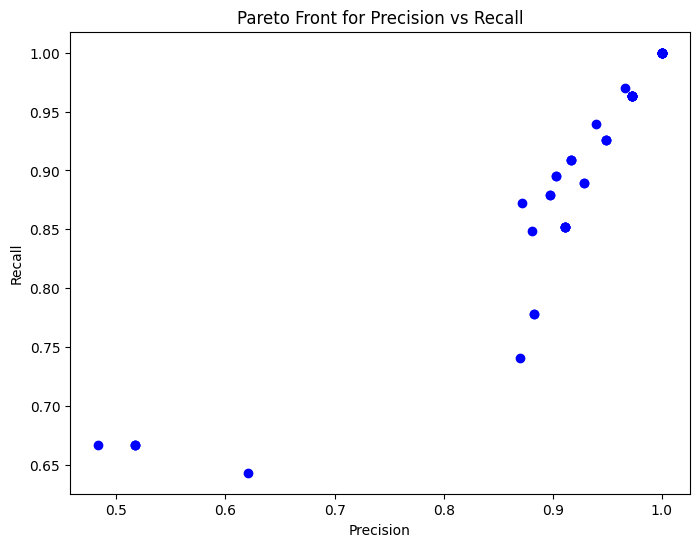

In [12]:
def plot_pareto_front(study):
    trials = study.trials
    precisions = [1 - trial.values[0] for trial in trials]
    recalls = [1 - trial.values[1] for trial in trials]

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.scatter(precisions, recalls, c='blue')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Pareto Front for Precision vs Recall')
    plt.show()

plot_pareto_front(study)